In [6]:
import nomic
import json
api_key_path = "/home/ubuntu/api_keys.json"

with open(api_key_path, 'r') as j:
    key = json.loads(j.read())['nomic']

nomic.login(key)

#- Scientific programming
import numpy as np
import pandas as pd
from tqdm import tqdm
from graspologic.embed import ClassicalMDS
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import balanced_accuracy_score as bas

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz

data_dir = '../../data/data/'
vote_str = '118-2024_h142'

dataset = pd.read_csv(f'{data_dir}{vote_str}.csv')
dataset.head()

,Unnamed: 0,person,state,district,vote,name,party,matched-name,twitter-handle,average-embd,matched-state,matched-party
0,0,400004,AL,4,Yea,Rep. Robert Aderholt [R],Republican,"Aderholt, Robert",robert_aderholt,"[0.020525227366267024, 0.04287387229300834, -0...",AL,R
1,1,400030,GA,2,Not Voting,Rep. Sanford Bishop [D],Democrat,"Bishop Jr., Sanford",sanfordbishop,"[0.011686148968609896, 0.034835316918113014, -...",GA,D
2,2,400033,OR,3,Yea,Rep. Earl Blumenauer [D],Democrat,NaN,NaN,NaN,NaN,NaN
3,3,400052,TX,26,Yea,Rep. Michael Burgess [R],Republican,"Burgess, Michael",michaelcburgess,"[0.019034768800315616, 0.05050808603658616, -0...",TX,R
4,4,400057,CA,41,Yea,Rep. Ken Calvert [R],Republican,"Calvert, Ken",kencalvert,"[0.020587250114365935, 0.04766320684325197, -0...",CA,R


Text(0.5, 1.0, 'CMDS // by vote')

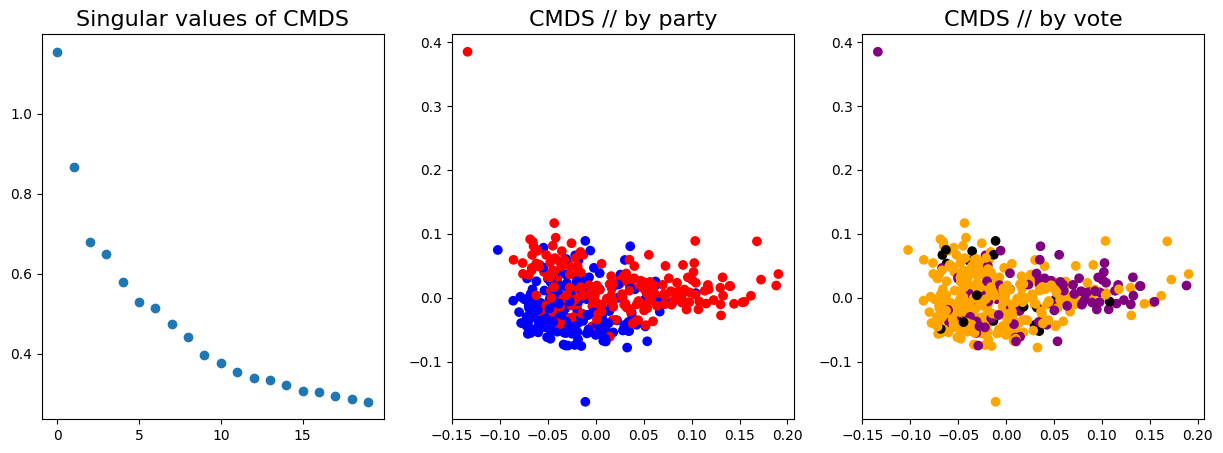

In [7]:
dataset = dataset.dropna(axis=0)

average_embd = np.array([eval(d) for d in dataset['average-embd'].values])
vote = [v for v in dataset['vote'].values]
party = [p for p in dataset['matched-party'].values]

cmds = ClassicalMDS(n_components=20)
_ = cmds.fit_transform(average_embd)
svs = cmds.singular_values_

cmds = ClassicalMDS()
cmds_embds = cmds.fit_transform(average_embd)

vote_colors = {
    'yea': 'orange',
    'nay': 'purple',
    'not voting': 'black'
}

party_colors = {
    'r': 'r',
    'd': 'b',
    'i': 'g'
}

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(range(len(svs)), svs)
ax[1].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[party_colors[p.lower()] for p in party])
ax[2].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[vote_colors[v.lower()] for v in vote])

ax[0].set_title('Singular values of CMDS', fontsize=16)
ax[1].set_title('CMDS // by party', fontsize=16)
ax[2].set_title('CMDS // by vote', fontsize=16)

Text(0.5, 1.02, 'Efficacy of representation+LR \n for 118-2024_h142')

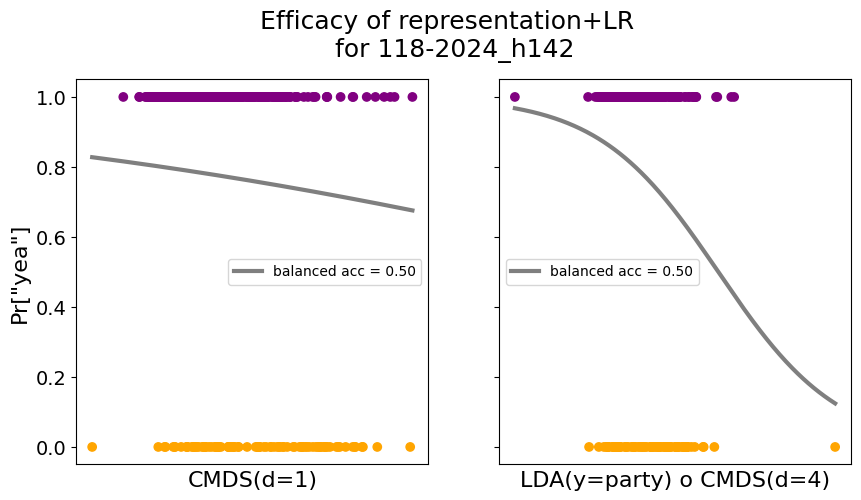

In [8]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

vote_inds = []
y = []
for i, v in enumerate(vote):
    if v.lower() == 'nay':
        y.append(0)
    elif v.lower() == 'yea':
        y.append(1)
    else:
        continue
    vote_inds.append(i)
    
vote_inds = np.array(vote_inds)
x = cmds_embds[vote_inds,:1]

vote_model = LogisticRegression()
vote_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y])
ax[0].scatter(x, y, c=color_list)

# Plot the logistic regression curve
er = bas(y, vote_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].legend()
ax[0].set_xlabel('CMDS(d=1)', fontsize=16)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[vote_inds], np.array(party)[vote_inds])
x = lda.transform(cmds_embds[vote_inds])

party_model = LogisticRegression()
party_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[1].scatter(x, y, c=color_list)

er = bas(y, party_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].legend()
ax[1].set_xlabel(f'LDA(y=party) o CMDS(d={cmds_embds.shape[1]})', fontsize=16)

for ax_ in ax:
    ax_.set_xticks([])
    ax_.tick_params(labelsize=14)

fig.suptitle(f'Efficacy of representation+LR \n for {vote_str}', fontsize=18, y=1.02)